# 코랩 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
git clone https://github.com/jeongjinmyung/jm-BERT-Tutorial.git

In [ ]:
! pip install -r requirements.txt

# 필요한 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
import os
import re
import json
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import pickle

import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelWithLMHead
from transformers import get_linear_schedule_with_warmup


# 결과 저장용 폴더생성

In [ ]:
result_dir = os.path.join(os.getcwd(), "results")
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)

# 데이터 불러오기
- 뉴스기사 대상 기계독해 데이터

In [ ]:
with open('./data/TL_text_entailment.json') as f:
    raw_js = json.loads(f.read())

In [ ]:
raw_js

{'Dataset': {'Identifier': 'TEXT_QnA_News_01',
  'name': '뉴스기사 대상 기계독해 데이터',
  'src_path': '/dataSet/text/',
  'label_path': '/dataSet/text/',
  'category': 2,
  'type': 0},
 'data': [{'doc_id': '01100201.20210502175653001',
   'doc_title': '민주당 새 당대표에 86맏형 송영길…최고위원은 ‘친문’ 강화',
   'doc_source': '국민일보',
   'doc_published': 20210502,
   'doc_class': {'class': '한국언론진흥재단 빅카인즈 뉴스기사', 'code': '정치'},
   'created': '20211217144113',
   'paragraphs': [{'context': '2022년 대통령 선거를 진두지휘할 여당의 신임 당대표에 5선 송영길 의원이 당선됐다. 함께 치러진 최고위원 선거에서는 김용민 강병원 백혜련 김영배 전혜숙 의원이 당원들의 선택을 받았다. 더불어민주당 당원들은 당대표 선거에서는 ‘쇄신’을 강조한 송 의원에게, 최고위원 선거에서는 문재인정부의 성공적인 마무리를 위한 ‘친문(친문재인) 지도부’ 구성에 힘을 실어준 것으로 평가된다. \n \n2일 서울 여의도 당사에서 열린 민주당 임시 전국대의원회의에서 송 신임 대표는 총득표율 35.60%로 홍영표 의원을 불과 0.59%포인트 차로 누르고 당권을 손에 쥐었다. 2위 홍 의원은 권리당원 투표에서 송 의원을 앞섰지만, 반영율이 더 큰 대의원 투표에서 밀렸다. \n \n송 신임 대표는 전당대회 직후 수락연설에서 “유능한 개혁, 언행일치의 민주당을 만들어 국민의 삶을 지켜내고, 국민의 마음을 얻겠다”며 “자랑스런 대선 주자들과 소통하면서 대선 경선을 공정하게 관리하겠다”고 강조했다. \n \n \n최고위원 선거에서는 민주당 초선모임 ‘처럼회’ 멤버로 중대범죄수사청 설치

In [ ]:
raw_data = raw_js["data"]

In [ ]:
raw_data

[{'doc_id': '01100201.20210502175653001',
  'doc_title': '민주당 새 당대표에 86맏형 송영길…최고위원은 ‘친문’ 강화',
  'doc_source': '국민일보',
  'doc_published': 20210502,
  'doc_class': {'class': '한국언론진흥재단 빅카인즈 뉴스기사', 'code': '정치'},
  'created': '20211217144113',
  'paragraphs': [{'context': '2022년 대통령 선거를 진두지휘할 여당의 신임 당대표에 5선 송영길 의원이 당선됐다. 함께 치러진 최고위원 선거에서는 김용민 강병원 백혜련 김영배 전혜숙 의원이 당원들의 선택을 받았다. 더불어민주당 당원들은 당대표 선거에서는 ‘쇄신’을 강조한 송 의원에게, 최고위원 선거에서는 문재인정부의 성공적인 마무리를 위한 ‘친문(친문재인) 지도부’ 구성에 힘을 실어준 것으로 평가된다. \n \n2일 서울 여의도 당사에서 열린 민주당 임시 전국대의원회의에서 송 신임 대표는 총득표율 35.60%로 홍영표 의원을 불과 0.59%포인트 차로 누르고 당권을 손에 쥐었다. 2위 홍 의원은 권리당원 투표에서 송 의원을 앞섰지만, 반영율이 더 큰 대의원 투표에서 밀렸다. \n \n송 신임 대표는 전당대회 직후 수락연설에서 “유능한 개혁, 언행일치의 민주당을 만들어 국민의 삶을 지켜내고, 국민의 마음을 얻겠다”며 “자랑스런 대선 주자들과 소통하면서 대선 경선을 공정하게 관리하겠다”고 강조했다. \n \n \n최고위원 선거에서는 민주당 초선모임 ‘처럼회’ 멤버로 중대범죄수사청 설치 등을 주장해 온 강성 친문 김용민 의원이 가장 많은 표를 얻었다. 역시 친문 진영으로 분류되는 강병원(재선) 김영배(초선) 전혜숙(3선) 의원이 지도부에 입성했다. 비주류 진영은 ‘조국 사태’ 등에 대해 쓴소리를 했던 재선의 백혜련 의원이 유일하다. \n \n송 신임 대표가 ‘범친문’으로 분류되긴 하지만 이번 전대기간 당의 전면적 쇄신

In [ ]:
code_list = [entry['doc_class']['code'] for entry in raw_data]

In [ ]:
code_list

['정치',
 '정치',
 '정치',
 '사회',
 '문화',
 '사회',
 '사회',
 '경제',
 '사회',
 '사회',
 '사회',
 '정치',
 '사회',
 '사회',
 '국제',
 '국제',
 '사회',
 '사회',
 '스포츠',
 '경제',
 '경제',
 '정치',
 '사회',
 '경제',
 '문화',
 '사회',
 '경제',
 '문화',
 '사회',
 '사회',
 '사회',
 '정치',
 '스포츠',
 '경제',
 '경제',
 '국제',
 '사회',
 '국제',
 '사회',
 'IT과학',
 'IT과학',
 '사회',
 '정치',
 '사회',
 '정치',
 '스포츠',
 '문화',
 '경제',
 '스포츠',
 '사회',
 '사회',
 '사회',
 '사회',
 '경제',
 '사회',
 '사회',
 '사회',
 '경제',
 '사회',
 '사회',
 '정치',
 '사회',
 '경제',
 '정치',
 '사회',
 '사회',
 '사회',
 '경제',
 '국제',
 '사회',
 '정치',
 '정치',
 '사회',
 '사회',
 '국제',
 '정치',
 '정치',
 '정치',
 '정치',
 '사회',
 '정치',
 '사회',
 '문화',
 '사회',
 '정치',
 '사회',
 'IT과학',
 '사회',
 '정치',
 '사회',
 '정치',
 'IT과학',
 '정치',
 '사회',
 '사회',
 '사회',
 '사회',
 '문화',
 '사회',
 '사회',
 '사회',
 '사회',
 '사회',
 '정치',
 '정치',
 '경제',
 '문화',
 '사회',
 '사회',
 '사회',
 '국제',
 '정치',
 '사회',
 '사회',
 '사회',
 '경제',
 '정치',
 '사회',
 '사회',
 'IT과학',
 '사회',
 '경제',
 '정치',
 '사회',
 '사회',
 '사회',
 '정치',
 '사회',
 '국제',
 '정치',
 '문화',
 '문화',
 '사회',
 '사회',
 '사회',
 '스포츠',
 '정치',
 'IT과학',
 '경제',
 '사회',
 '경

In [ ]:
context_list = [entry['paragraphs'][0]['context'] for entry in raw_data]

In [ ]:
context_list

['2022년 대통령 선거를 진두지휘할 여당의 신임 당대표에 5선 송영길 의원이 당선됐다. 함께 치러진 최고위원 선거에서는 김용민 강병원 백혜련 김영배 전혜숙 의원이 당원들의 선택을 받았다. 더불어민주당 당원들은 당대표 선거에서는 ‘쇄신’을 강조한 송 의원에게, 최고위원 선거에서는 문재인정부의 성공적인 마무리를 위한 ‘친문(친문재인) 지도부’ 구성에 힘을 실어준 것으로 평가된다. \n \n2일 서울 여의도 당사에서 열린 민주당 임시 전국대의원회의에서 송 신임 대표는 총득표율 35.60%로 홍영표 의원을 불과 0.59%포인트 차로 누르고 당권을 손에 쥐었다. 2위 홍 의원은 권리당원 투표에서 송 의원을 앞섰지만, 반영율이 더 큰 대의원 투표에서 밀렸다. \n \n송 신임 대표는 전당대회 직후 수락연설에서 “유능한 개혁, 언행일치의 민주당을 만들어 국민의 삶을 지켜내고, 국민의 마음을 얻겠다”며 “자랑스런 대선 주자들과 소통하면서 대선 경선을 공정하게 관리하겠다”고 강조했다. \n \n \n최고위원 선거에서는 민주당 초선모임 ‘처럼회’ 멤버로 중대범죄수사청 설치 등을 주장해 온 강성 친문 김용민 의원이 가장 많은 표를 얻었다. 역시 친문 진영으로 분류되는 강병원(재선) 김영배(초선) 전혜숙(3선) 의원이 지도부에 입성했다. 비주류 진영은 ‘조국 사태’ 등에 대해 쓴소리를 했던 재선의 백혜련 의원이 유일하다. \n \n송 신임 대표가 ‘범친문’으로 분류되긴 하지만 이번 전대기간 당의 전면적 쇄신을 요구해왔고, 친문 강성 지지층에 대한 쓴소리도 아끼지 않았다는 점에서 당내 긴장 상황이 조성될 수 있다는 우려가 일각에서 나온다. 특히 친문 핵심인 윤호중 원내대표는 물론 선출직 최고위원 5명 중 4명이 친문 진영인 상황에서 이들과 얼마나 호흡을 맞출 수 있느냐도 정치권의 관심사다. \n \n1963년 전남 고흥에서 태어난 송 신임 대표는 인천 계양을에서 16대, 17대, 18대, 20대, 21대 국회의원을 지냈다. 2010년부터 4년간 인천시장을 역임했다. \n ',
 

# 데이터 프레임 형태로 만들기

In [ ]:
df_v1 = pd.DataFrame({'context': context_list, 'code': code_list})

In [ ]:
df_v1

context  code
0      2022년 대통령 선거를 진두지휘할 여당의 신임 당대표에 5선 송영길 의원이 당선됐...    정치
1      북한이 2일 대남·대미 담화 3건을 동시다발적으로 발표하면서 남측과 미국을 맹비난했...    정치
2      서울시는 코로나19 완치자의 빠른 일상 회복을 돕기 위해 4주간 건강관리서비스를 지...    정치
3      전남도소방본부가 전국 최초로 사회적·경제적 취약계층으로 찾아가는 ‘119생활안전전담...    사회
4      여성가족부가 지난달 27일 ‘제4차 건강가정기본계획(2021~2025)’을 통해 난...    문화
...                                                  ...   ...
24004  연세대학교 신촌캠퍼스에 위치한 연세우유 서울사무소에서 14일 코로나19 확진자가 나...    사회
24005  아베 신조 일본 총리가 최근 현지에서 논란을 빚은 '검찰청법 개정안' 관련 재차 "...    사회
24006  서울사이버대학교는 K-MOOC 플랫폼을 통해 5개 과정 강좌를 무료로 제공한다고 1...  IT과학
24007  SK에너지가 모빌리티 고객을 대상으로 한 차량관리 통합 서비스 개발에 본격 착수했다...    사회
24008  서울 용산 철도정비창 부지 인근 지역이 오늘(14일) 토지거래허가구역으로 지정된다....    사회

[24009 rows x 2 columns]

In [ ]:
df_v1['code'].value_counts()

사회      7825
경제      5931
정치      2643
문화      2320
국제      2012
스포츠     1184
IT과학    1015
기타       653
지역       426
Name: code, dtype: int64

'기타', '지역' 라벨 삭제

In [ ]:
labels_to_remove = ['기타', '지역']
df_v2 = df_v1[~df_v1['code'].isin(labels_to_remove)]

In [ ]:
df_v2['code'].value_counts()

사회      7825
경제      5931
정치      2643
문화      2320
국제      2012
스포츠     1184
IT과학    1015
Name: code, dtype: int64

# 전처리 진행

In [ ]:
def cleantext(text):
    text = text.strip()
    text = re.sub(r"[a-zA-Z]+", "", text)   # 영어 삭제
    text = re.sub(r"[^\w\s_]", "", text)   # 특수문자 제거
    text = re.sub('\n', ' ', text)  # 줄바꿈 제거
    text = re.sub('\t', ' ', text)  # 탭 제거
    text = re.sub(r"\b\d+\b", "", text) # 숫자 제거
    text = re.sub(r"\d+", "", text) # 단독 숫자 제거
    text = re.sub('[\u4e00-\u9fff]+', '', text) # 한자 삭제
    text = re.sub(r" +", ' ', text) # 연속된 띄어쓰기 제거
    text = text.strip()
    return text

전처리한 문장을 새로운 열에 추가

In [ ]:
df_v2['cleaned_text'] = df_v2['context'].apply(lambda x : cleantext(x))

C:\Users\cbml\AppData\Local\Temp\ipykernel_37516\2325738462.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v2['cleaned_text'] = df_v2['context'].apply(lambda x : cleantext(x))


In [ ]:
df_v2

context  code  \
0      2022년 대통령 선거를 진두지휘할 여당의 신임 당대표에 5선 송영길 의원이 당선됐...    정치   
1      북한이 2일 대남·대미 담화 3건을 동시다발적으로 발표하면서 남측과 미국을 맹비난했...    정치   
2      서울시는 코로나19 완치자의 빠른 일상 회복을 돕기 위해 4주간 건강관리서비스를 지...    정치   
3      전남도소방본부가 전국 최초로 사회적·경제적 취약계층으로 찾아가는 ‘119생활안전전담...    사회   
4      여성가족부가 지난달 27일 ‘제4차 건강가정기본계획(2021~2025)’을 통해 난...    문화   
...                                                  ...   ...   
24004  연세대학교 신촌캠퍼스에 위치한 연세우유 서울사무소에서 14일 코로나19 확진자가 나...    사회   
24005  아베 신조 일본 총리가 최근 현지에서 논란을 빚은 '검찰청법 개정안' 관련 재차 "...    사회   
24006  서울사이버대학교는 K-MOOC 플랫폼을 통해 5개 과정 강좌를 무료로 제공한다고 1...  IT과학   
24007  SK에너지가 모빌리티 고객을 대상으로 한 차량관리 통합 서비스 개발에 본격 착수했다...    사회   
24008  서울 용산 철도정비창 부지 인근 지역이 오늘(14일) 토지거래허가구역으로 지정된다....    사회   

                                            cleaned_text  
0      년 대통령 선거를 진두지휘할 여당의 신임 당대표에 선 송영길 의원이 당선됐다 함께 ...  
1      북한이 일 대남대미 담화 건을 동시다발적으로 발표하면서 남측과 미국을 맹비난했다 북...  
2      서울시는 코로나 완치자의 빠른 일상 회복을 돕기 위해 주간 건강관리서비스를 지원하고...  
3      전남도소방본부가 전국 최초로 사회적경제적 취약계층으로 찾아가는 생활안전전담대를 운영...  
4      여성가족부가 지난달 일 제차 건강가정기본계획을 통해 난자정자 공여나 대리출산 등으로...  
...                                                  ...  
24004  연세대학교 신촌캠퍼스에 위치한 연세우유 서울사무소에서 일 코로나 확진자가 나왔다 확...  
24005  아베 신조 일본 총리가 최근 현지에서 논란을 빚은 검찰청법 개정안 관련 재차 자의적...  
24006  서울사이버대학교는 플랫폼을 통해 개 과정 강좌를 무료로 제공한다고 일 밝혔다 강좌는...  
24007  에너지가 모빌리티 고객을 대상으로 한 차량관리 통합 서비스 개발에 본격 착수했다 에...  
24008  서울 용산 철도정비창 부지 인근 지역이 오늘일 토지거래허가구역으로 지정된다 이에 따...  

[22930 rows x 3 columns]

전처리 후에 빈 문자열이 생겼으면 null값으로 변경한 후 제거

In [ ]:
df_v2 = df_v2.replace('', np.nan).dropna(subset=['cleaned_text']).reset_index(drop=True)

null 값이 있진 않은지 확인

In [ ]:
df_v2.isnull().sum()

context         0
code            0
cleaned_text    0
dtype: int64

# 라벨 인코딩

In [ ]:
labelencoder = LabelEncoder()
df_v2['label'] = (labelencoder.fit_transform(df_v2['code'])).astype('int')

In [ ]:
df_v2

context  code  \
0      2022년 대통령 선거를 진두지휘할 여당의 신임 당대표에 5선 송영길 의원이 당선됐...    정치   
1      북한이 2일 대남·대미 담화 3건을 동시다발적으로 발표하면서 남측과 미국을 맹비난했...    정치   
2      서울시는 코로나19 완치자의 빠른 일상 회복을 돕기 위해 4주간 건강관리서비스를 지...    정치   
3      전남도소방본부가 전국 최초로 사회적·경제적 취약계층으로 찾아가는 ‘119생활안전전담...    사회   
4      여성가족부가 지난달 27일 ‘제4차 건강가정기본계획(2021~2025)’을 통해 난...    문화   
...                                                  ...   ...   
22925  연세대학교 신촌캠퍼스에 위치한 연세우유 서울사무소에서 14일 코로나19 확진자가 나...    사회   
22926  아베 신조 일본 총리가 최근 현지에서 논란을 빚은 '검찰청법 개정안' 관련 재차 "...    사회   
22927  서울사이버대학교는 K-MOOC 플랫폼을 통해 5개 과정 강좌를 무료로 제공한다고 1...  IT과학   
22928  SK에너지가 모빌리티 고객을 대상으로 한 차량관리 통합 서비스 개발에 본격 착수했다...    사회   
22929  서울 용산 철도정비창 부지 인근 지역이 오늘(14일) 토지거래허가구역으로 지정된다....    사회   

                                            cleaned_text  label  
0      년 대통령 선거를 진두지휘할 여당의 신임 당대표에 선 송영길 의원이 당선됐다 함께 ...      6  
1      북한이 일 대남대미 담화 건을 동시다발적으로 발표하면서 남측과 미국을 맹비난했다 북...      6  
2      서울시는 코로나 완치자의 빠른 일상 회복을 돕기 위해 주간 건강관리서비스를 지원하고...      6  
3      전남도소방본부가 전국 최초로 사회적경제적 취약계층으로 찾아가는 생활안전전담대를 운영...      4  
4      여성가족부가 지난달 일 제차 건강가정기본계획을 통해 난자정자 공여나 대리출산 등으로...      3  
...                                                  ...    ...  
22925  연세대학교 신촌캠퍼스에 위치한 연세우유 서울사무소에서 일 코로나 확진자가 나왔다 확...      4  
22926  아베 신조 일본 총리가 최근 현지에서 논란을 빚은 검찰청법 개정안 관련 재차 자의적...      4  
22927  서울사이버대학교는 플랫폼을 통해 개 과정 강좌를 무료로 제공한다고 일 밝혔다 강좌는...      0  
22928  에너지가 모빌리티 고객을 대상으로 한 차량관리 통합 서비스 개발에 본격 착수했다 에...      4  
22929  서울 용산 철도정비창 부지 인근 지역이 오늘일 토지거래허가구역으로 지정된다 이에 따...      4  

[22930 rows x 4 columns]

인코딩 결과 확인

In [ ]:
encoding_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(encoding_mapping)

{'IT과학': 0, '경제': 1, '국제': 2, '문화': 3, '사회': 4, '스포츠': 5, '정치': 6}


# 전처리 결과 확인

<Axes: >

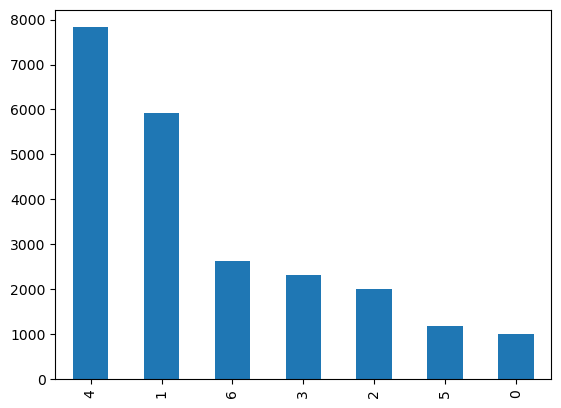

In [ ]:
df_v2.label.value_counts().plot.bar()

샘플 최대 길이 : 1910
샘플 최소 길이 : 135
샘플 평균 길이 : 980.0453118185783


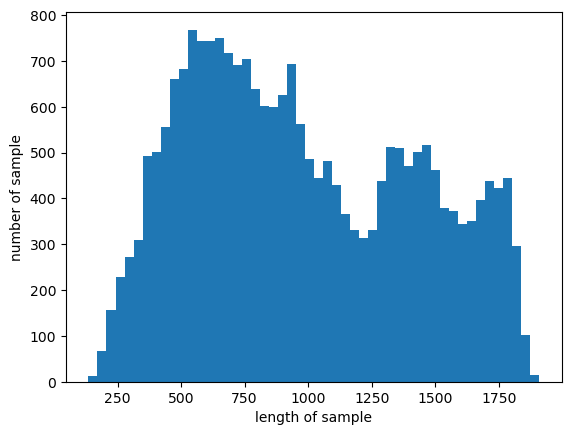

In [ ]:
sentences = df_v2.cleaned_text.values

sentence_max_len = max(len(l) for l in sentences)
sentence_min_len = min(len(l) for l in sentences)
sentence_mean_len = sum(map(len, sentences))/len(sentences)
print(f'샘플 최대 길이 : {sentence_max_len}')
print(f'샘플 최소 길이 : {sentence_min_len}')
print(f'샘플 평균 길이 : {sentence_mean_len}')
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

길이 1500자 이하의 데이터만 사용하고 싶음

In [ ]:
df_v3 = df_v2[df_v2['cleaned_text'].str.len().between(0, 1500)].reset_index(drop=True)

샘플 최대 길이 : 1500
샘플 최소 길이 : 135
샘플 평균 길이 : 842.7896605744126


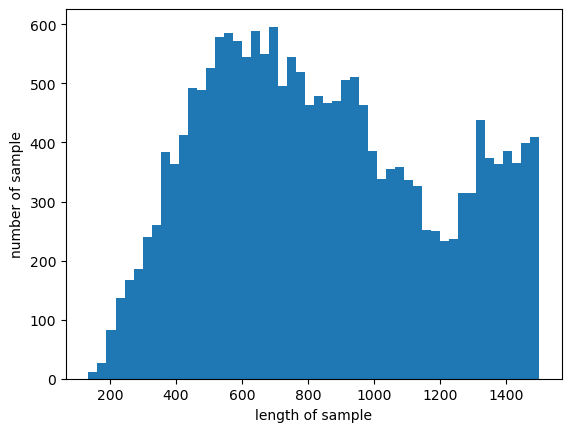

In [ ]:
sentences = df_v3.cleaned_text.values

sentence_max_len = max(len(l) for l in sentences)
sentence_min_len = min(len(l) for l in sentences)
sentence_mean_len = sum(map(len, sentences))/len(sentences)
print(f'샘플 최대 길이 : {sentence_max_len}')
print(f'샘플 최소 길이 : {sentence_min_len}')
print(f'샘플 평균 길이 : {sentence_mean_len}')
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

라벨 갯수를 400개로 동일하게 맞추고 싶음

In [ ]:
def sample_data_by_label(dataframe, label_column, label_values, num_samples, random_state):
    sampled_data = pd.concat(
        [dataframe[dataframe[label_column] == label].sample(n=num_samples,
                                                            random_state=random_state)
                            for label in label_values], ignore_index=True)
    return sampled_data

In [ ]:
label_list = df_v3["label"].unique().tolist()
print(label_list)

[6, 4, 1, 2, 5, 3, 0]


In [ ]:
df_v4 = sample_data_by_label(df_v3, 'label', label_list, 400, random_state=42)

<Axes: >

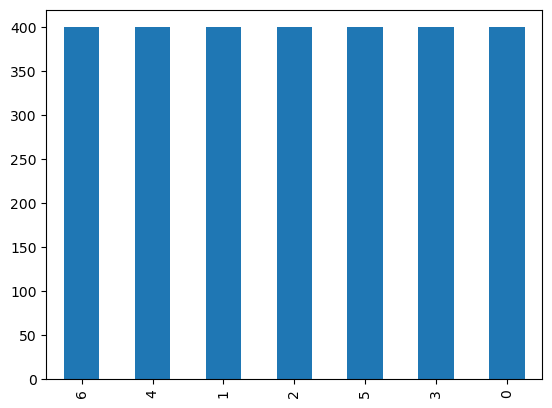

In [ ]:
df_v4.label.value_counts().plot.bar()

In [ ]:
df_v4

context  code  \
0     더불어민주당 대선 주자인 정세균 전 국무총리는 29일 일본 정부가 도쿄올림픽 지도에...    정치   
1     국가정보원이 이명박(MB)정부 당시인 2009년 말 청와대 지시로 여야 국회의원 등...    정치   
2     부동산 세제 완화를 향해 내달리던 송영길호가 브레이크를 밟았다. 청와대와 정부는 물...    정치   
3     2030 부산월드엑스포 민간 유치위원장에 당초 대기업 총수급 인사를 ‘원톱’으로 내...    정치   
4     박범계 법무부 장관은 18일 신현수 청와대 민정수석이 검찰 인사 과정에서 불만을 품...    정치   
...                                                 ...   ...   
2795  삼성전자가 4일 대학생·대학원생을 위한 모바일·IT 전용 온라인 쇼핑몰인 ‘갤럭시 ...  IT과학   
2796  \n개인정보보호위원회가 고객정보 관리를 소홀히 하거나 개인정보를 유출한 LG유플러스...  IT과학   
2797  플렉스온㈜(대표이사 이준)은 유전자 분석 및 피부 측정을 통한 맞춤형 화장품 브랜드...  IT과학   
2798  2021학년도 인하대학교(총장 조명우) 정시모집 원서접수 결과 1036명 모집(정원...  IT과학   
2799  유난히 길었던 장마와 덥지 않았던 지난해 여름과 달리 올여름은 때 이른 무더위가 예...  IT과학   

                                           cleaned_text  label  
0     더불어민주당 대선 주자인 정세균 전 국무총리는 일 일본 정부가 도쿄올림픽 지도에 독...      6  
1     국가정보원이 이명박정부 당시인 년 말 청와대 지시로 여야 국회의원 등 주요 인사에 ...      6  
2     부동산 세제 완화를 향해 내달리던 송영길호가 브레이크를 밟았다 청와대와 정부는 물론...      6  
3     부산월드엑스포 민간 유치위원장에 당초 대기업 총수급 인사를 원톱으로 내세우려던 정부...      6  
4     박범계 법무부 장관은 일 신현수 청와대 민정수석이 검찰 인사 과정에서 불만을 품고 ...      6  
...                                                 ...    ...  
2795  삼성전자가 일 대학생대학원생을 위한 모바일 전용 온라인 쇼핑몰인 갤럭시 캠퍼스 스토...      0  
2796  개인정보보호위원회가 고객정보 관리를 소홀히 하거나 개인정보를 유출한 유플러스와 일부...      0  
2797  플렉스온대표이사 이준은 유전자 분석 및 피부 측정을 통한 맞춤형 화장품 브랜드인 블...      0  
2798  학년도 인하대학교총장 조명우 정시모집 원서접수 결과 명 모집정원내에 명이 지원해 대...      0  
2799  유난히 길었던 장마와 덥지 않았던 지난해 여름과 달리 올여름은 때 이른 무더위가 예...      0  

[2800 rows x 4 columns]

In [ ]:
# 행 섞어준 후
# train : validation : test = 2000, 400, 400으로 나누고 싶음
df_v4 = df_v4.sample(frac=1).reset_index(drop=True)
df_v4 = df_v4[['cleaned_text', 'label']]
df_v4.rename(columns={'cleaned_text':'text'}, inplace=True)
train_df = df_v4[:2000]
valid_df = df_v4[2000:2400]
test_df = df_v4[2400:]

# 데이터 저장

In [ ]:
train_df.to_csv(os.path.join(os.getcwd(), './data/train_df.csv'), index=False)
valid_df.to_csv(os.path.join(os.getcwd(), './data/valid_df.csv'), index=False)
test_df.to_csv(os.path.join(os.getcwd(), './data/test_df.csv'), index=False)

# 데이터 불러오기

In [ ]:
train_data = pd.read_csv(os.path.join(os.getcwd(), './data/train_df.csv'))
valid_data = pd.read_csv(os.path.join(os.getcwd(), './data/valid_df.csv'))
test_data = pd.read_csv(os.path.join(os.getcwd(), './data/test_df.csv'))

# 학습 config 설정

In [ ]:
class Args():
    seed = 42
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    epochs = 4
    batch_size = 4
    sentence_max_len = 300
    learning_rate = 2e-5
    eps = 1e-8
    eval_step = 40
    num_classes = 7
    model_name = "beomi/kcbert-base"
    tokenizer_name = "beomi/kcbert-base"

args = Args()

# 시드 고정

In [ ]:
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

# 토크나이징
- 모델과 토크나이저 불러오기

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

def load_model_and_tokenizer(model_name, tokenizer_name, num_classes):
    model = AutoModelForSequenceClassification.from_pretrained(
                                            model_name,
                                            num_labels = num_classes,
                                            output_attentions = False,
                                            output_hidden_states = False,
                                            )
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    return model, tokenizer

In [ ]:
model, tokenizer = load_model_and_tokenizer(args.model_name, args.tokenizer_name, num_classes=7)

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly i

토큰화 결과

In [ ]:
print('Original: ', train_data.text[0])
print('Tokenized: ', tokenizer.tokenize(train_data.text[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_data.text[0])))

Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 300). Running this sequence through the model will result in indexing errors


Original:  담원 기아가 경기 연속 승전고를 울렸다 담원 기아는 일 온라인으로 진행된 챔피언스 코리아 스프링 시즌 정규 리그 라운드 경기에서 에 세트스코어 대 로 승리했다 담원 기아는 이날 승리로 승패세트득실 를 기록했다 변함없이 리그 선두 자리를 지켰다 은 승패세트득실 를 기록했다 순위표에선 그대로 위 자리에 머물렀다 팽팽한 접전이 펼쳐진 시리즈였다 담원 기아가 먼저 승점을 챙겼다 정글러 개입 없이 분 만에 바텀과 미드에서 킬을 신고하면서 좋은 흐름을 탔다 담원 기아는 분경 클로저 이주현이렐리아에게 두 번째 데스를 안겼고 분경 협곡의 전령을 사냥하면서 게임 주도권을 얻어냈다 담원 기아의 운영은 물 흐르듯 자연스러웠다 담원 기아는 분경 미드 교전에서 에이스를 띄웠다 분 뒤 내셔 남작을 사냥했다 분경 화염 드래곤 전투에서 킬을 더한 담원 기아는 쇼메이커 허수빅토르의 상대 넥서스 앞 순간 이동으로 게임을 끝냈다 이 케리아 류민석노틸러스의 하드 캐리로 세트를 승리해 따라붙었다 은 분경 바텀 전투에서 이주현루시안의 한발 빠른 합류로 킬을 챙겼다 분경 류민석이 허수신드라와 베릴 조건희세라핀를 낚아채면서 이 만든 스노우볼은 더 커졌다 양 팀의 대치전은 분경 화염 드래곤 전투에서 끝났다 이 오너 문현준릴리아의 이니시에이팅으로 교전을 열어 에이스를 띄웠다 은 전리품으로 내셔 남작 버프를 챙겼다 재정비 후 탑으로 회전한 은 허수를 비롯한 담원 인을 순서대로 처치하면서 승리를 확정지었다 한 세트를 내준 담원 기아가 갱플랭크 니달리를 선택해 상체에 힘을 싣는 전략으로 선회했다 담원 기아는 초반에 캐니언 김건부니달리의 바텀 탑 갱킹으로 연속 득점하며 이득을 봤다 분경 미드 교전에서도 이주현라이즈의 무리수를 잘 받아쳐 킬을 챙겼다 담원 기아는 분경 미드에 힘을 모아 억제기를 부쉈다 분 뒤엔 칸 김동하갱플랭크의 희생으로 내셔 남작을 사냥했다 이들은 직후 펼쳐진 교전에서도 절묘한 어그로 핑퐁을 성공시켜 에이스를 띄웠다 성장 격차를 벌린 담원 기아는 재정비 후 화염 드래곤 전투에서

# 데이터셋 만들기

pytorch dataset을 상속받으면 init, len, getitem 메서드를 지정해줘야함

In [ ]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.labels = [label for label in df['label']]
        self.texts = [self.tokenizer.encode_plus(
                                text,                       # batch의 text를 받아 인코딩
                                padding = 'max_length',     # max_length까지 패딩
                                add_special_tokens = True,  #[CLS], [SEP]과 같은 special token 추가
                                max_length=self.max_length, # 최대 문장 길이 설정
                                truncation=True,            # 설정한 길이 이상의 토큰은 truncation
                                return_tensors="pt")        # pytorch tensor로 추출
                                for text in df['text']]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [ ]:
train_dataset = MyDataset(df=train_data, tokenizer=tokenizer, max_length=args.sentence_max_len)
valid_dataset = MyDataset(df=valid_data, tokenizer=tokenizer, max_length=args.sentence_max_len)
test_dataset = MyDataset(df=test_data, tokenizer=tokenizer, max_length=args.sentence_max_len)

데이터로더에 담기

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)  # train dataset은 섞어줘야함
valid_dataloader = DataLoader(valid_dataset, batch_size=args.batch_size)                  # validation dataset은 반드시 섞을 필요는 없음
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size)

In [ ]:
# batch size인 4개씩 데이터를 자른 것을 볼 수 있음
# train dataloader는 shuffle로 인해 돌릴때마다 다른 결과가 나옴
next(iter(valid_dataloader))

[{'input_ids': tensor([[[    2, 20643,   743,  ...,  4008,  1849,     3]],
 
         [[    2, 19246, 12258,  ..., 19246, 12258,     3]],
 
         [[    2, 12472,  4072,  ...,  1931,  4605,     3]],
 
         [[    2,  2850,  4887,  ...,     0,     0,     0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 1, 1, 1]],
 
         [[1, 1, 1,  ..., 1, 1, 1]],
 
         [[1, 1, 1,  ..., 1, 1, 1]],
 
         [[1, 1, 1,  ..., 0, 0, 0]]])},
 tensor([3, 0, 1, 4])]

# 모델 확인

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(300, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30000, 768)
bert.embeddings.position_embeddings.weight                (300, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

# 학습 준비

- 학습에 필요한 기타 함수 생성

In [ ]:
# 예측값과 라벨을 활용하여 정확도를 계산하는 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

- 옵티마이저 설정
- 스케줄러 지정

In [ ]:
optimizer = AdamW(model.parameters(), lr=args.learning_rate, eps=args.eps)
total_steps = len(train_dataloader) * args.epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

# Train 설정

In [ ]:
def train():

    # 학습 결과 저장
    training_stats = []

    model.to(args.device)

    for epoch in range(args.epochs):

        # 실제 학습이 진행된 cuda 시간 측정
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)

        start_event.record()

        # train 결과 저장
        total_train_loss = 0
        # 모델 학습
        model.train()
        for train_input, train_label in tqdm(train_dataloader):

            trian_input_ids = train_input['input_ids'].squeeze(1).to(args.device)
            train_input_mask = train_input['attention_mask'].to(args.device)
            train_label = train_label.to(args.device)

            optimizer.zero_grad()

            outputs = model(
                        trian_input_ids,
                        token_type_ids = None,
                        attention_mask = train_input_mask,
                        labels = train_label
                    )

            loss, logits = outputs['loss'], outputs['logits']

            total_train_loss += loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)

        # validation
        model.eval()
        # validation 결과 저장
        total_eval_accuracy = 0
        total_eval_loss = 0

        for val_input, val_label in valid_dataloader:
            valid_input_ids = val_input['input_ids'].squeeze(1).to(args.device)
            valid_input_mask = val_input['attention_mask'].to(args.device)
            valid_label = val_label.to(args.device)

            with torch.no_grad():
                outputs = model(
                    valid_input_ids,
                    token_type_ids = None,
                    attention_mask = valid_input_mask,
                    labels = valid_label
                )

                loss, logits = outputs['loss'], outputs['logits']

            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = valid_label.to('cpu').numpy()

            total_eval_accuracy += flat_accuracy(logits, label_ids)

        avg_val_loss = total_eval_loss / len(valid_dataloader)
        avg_val_accuracy = total_eval_accuracy / len(valid_dataloader)

        end_event.record()
        torch.cuda.synchronize()
        elapsed_time = start_event.elapsed_time(end_event)

        training_stats.append(
            {
                "Epoch": epoch+1,
                "Train_Loss": avg_train_loss,
                'Valid_Loss': avg_val_loss,
                'Valid_Accuracy': avg_val_accuracy,
                'Elapsed_Time': elapsed_time
            }
        )

        print(
            f"Epochs: {epoch + 1} \
            | Train Loss: {avg_train_loss: .3f} \
            | Val Loss: {avg_val_loss: .3f} \
            | Val Accuracy: {avg_val_accuracy: .3f} \
            | Elapsed time: {elapsed_time: .3f} ms"
            )

        torch.save(model, os.path.join(result_dir, f'BERT_Classification_{epoch+1}epoch.pt'))

    # 결과 저장
    with open(os.path.join(result_dir, 'training_results.pickle'), 'wb') as fw:
        pickle.dump(training_stats, fw)

# Train!

In [ ]:
train()

100%|██████████| 500/500 [01:29<00:00,  5.60it/s]


Epochs: 1             | Train Loss:  0.961             | Val Loss:  0.819             | Val Accuracy:  0.725             | Elapsed time:  94431.891 ms


100%|██████████| 500/500 [01:28<00:00,  5.67it/s]


Epochs: 2             | Train Loss:  0.561             | Val Loss:  0.860             | Val Accuracy:  0.775             | Elapsed time:  93405.828 ms


100%|██████████| 500/500 [01:32<00:00,  5.41it/s]


Epochs: 3             | Train Loss:  0.314             | Val Loss:  1.081             | Val Accuracy:  0.760             | Elapsed time:  97715.125 ms


100%|██████████| 500/500 [01:30<00:00,  5.52it/s]


Epochs: 4             | Train Loss:  0.164             | Val Loss:  1.106             | Val Accuracy:  0.780             | Elapsed time:  96000.203 ms


# 학습 결과 확인하기

In [ ]:
# 데이터프레임으로 만들기
with open(os.path.join(result_dir,'training_results.pickle'), 'rb') as fr:
    training_stats = pickle.load(fr)

pd.set_option('display.precision',2)
df_result = pd.DataFrame(data=training_stats)
df_result = df_result.set_index('Epoch')
df_result

Train_Loss  Valid_Loss  Valid_Accuracy  Elapsed_Time
Epoch                                                      
1            0.96        0.82            0.72      94431.89
2            0.56        0.86            0.78      93405.83
3            0.31        1.08            0.76      97715.12
4            0.16        1.11            0.78      96000.20

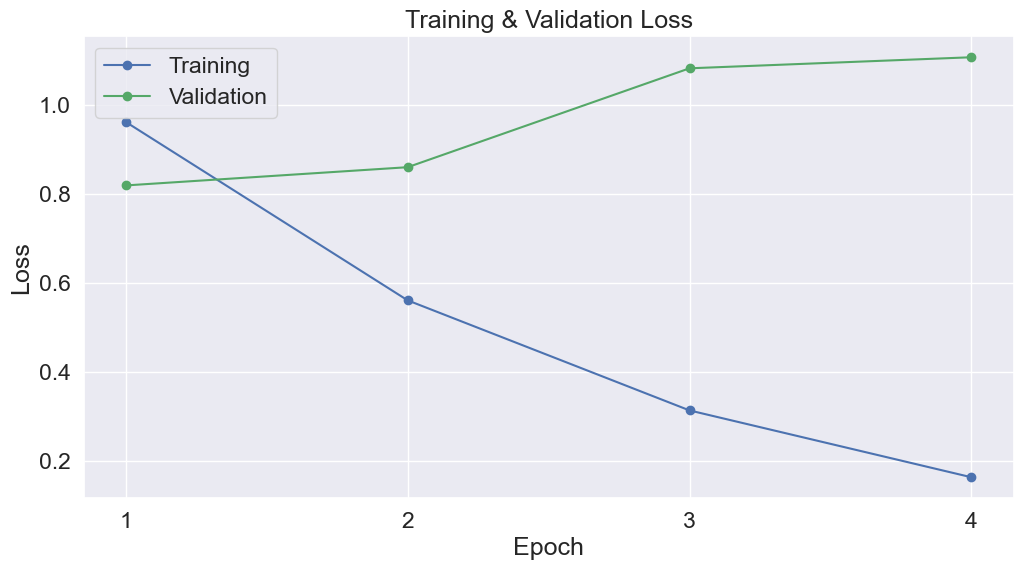

In [ ]:
# 그래프
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_result['Train_Loss'], 'b-o', label="Training")
plt.plot(df_result['Valid_Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.savefig(os.path.join(result_dir,"result.png"))
plt.show()

# 모델 추론

In [ ]:
try:
  trained_model = torch.load(os.path.join(result_dir, 'BERT_Classification_3epoch.pt'))
  print('모델 불러오기 성공!')
except:
  print('error!!')

trained_model.eval()

predictions , true_labels = [], []

for test_input, test_label in tqdm(test_dataloader):
  test_input_ids = test_input['input_ids'].squeeze(1).to(args.device)
  test_input_mask = test_input['attention_mask'].to(args.device)
  test_label = test_label.to(args.device)

  with torch.no_grad():
    outputs = model(
        test_input_ids,
        token_type_ids = None,
        attention_mask = test_input_mask,
        labels = test_label
    )

  logits = outputs['logits']

  logits = logits.detach().cpu().numpy()
  label_ids = test_label.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

모델 불러오기 성공!


100%|██████████| 100/100 [00:05<00:00, 17.67it/s]


In [ ]:
flat_predictions = np.argmax(np.concatenate(predictions, axis=0), axis=1)
flat_true_labels = np.concatenate(true_labels, axis=0)

# 정확도 확인
accuracy = np.sum(flat_predictions == flat_true_labels) / len(flat_true_labels)
test_result = f"Test Accuracy: {accuracy}"
print(test_result)

Test Accuracy: 0.8


# 추론 결과 텍스트로 저장하기

In [ ]:
with open(os.path.join(result_dir, "TestResult.txt"), "w") as f:
    f.write(test_result)